# Transformer Notebook

- Notebook 4 of the 4.
- This notebook has the implementation of Transformer for sentiment analysis on the IMDB Reviews dataset.
- The first notebook of the series implements Neural Bag of Words(NBoW), while the second implements Recurrent Neural Network(RNN) and the third notebook of the series implements Convolutional Neural Network(CNN) for sentiment analysis.

##### Installing the correct version of torchtext and PyTorch to avoid crash.

In [1]:
pip install torch==2.2.0 torchtext==0.17.0

Note: you may need to restart the kernel to use updated packages.


##### Importing all the libraries.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import collections
import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

##### Loading the dataset.

In [4]:
train_data, test_data = datasets.load_dataset("imdb", split = ["train", "test"])

##### Initializing the tokenizer.

In [5]:
transformer_name = "bert-base-uncased" # Case sensitivity is not necessary.

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
tokenizer.tokenize("hello world!")

['hello', 'world', '!']

In [7]:
tokenizer.encode("hello world!")

[101, 7592, 2088, 999, 102]

In [8]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

['[CLS]', 'hello', 'world', '[SEP]']

In [9]:
tokenizer("hello world!")

{'input_ids': [101, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

##### Function for adding the ids column.

In [10]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

In [11]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [12]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [13]:
tokenizer.vocab["!"]

999

In [14]:
tokenizer.pad_token

'[PAD]'

In [15]:
tokenizer.pad_token_id

0

In [16]:
tokenizer.vocab[tokenizer.pad_token]

0

##### Storing the pad index.

In [17]:
pad_index = tokenizer.pad_token_id

##### Validation set.

In [18]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

##### Converting to tensors.

In [19]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [20]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [21]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [22]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [23]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [24]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [25]:
transformer.config.hidden_size

768

In [26]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 109,483,778 trainable parameters


In [28]:
lr = 1e-5 # Learning Rate 

optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
criterion = nn.CrossEntropyLoss()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [31]:
model = model.to(device)
criterion = criterion.to(device)

In [32]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [33]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [34]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [35]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt") # Saving the state dict of the model
    print(f"epoch: {epoch}")
    print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_acc:.3f}")

training...:   0%|          | 0/2344 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
evaluating...: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


epoch: 0
Training Loss: 0.251, Training Accuracy: 0.894
Validation Loss: 0.214, Validation Accuracy: 0.921


evaluating...: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


epoch: 1
Training Loss: 0.134, Training Accuracy: 0.952
Validation Loss: 0.200, Validation Accuracy: 0.929


evaluating...: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]

epoch: 2
Training Loss: 0.070, Training Accuracy: 0.977
Validation Loss: 0.241, Validation Accuracy: 0.927


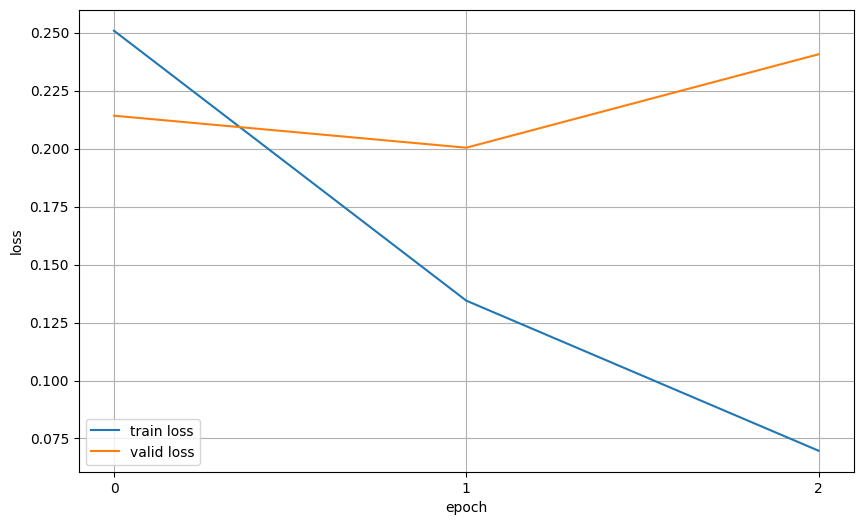

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

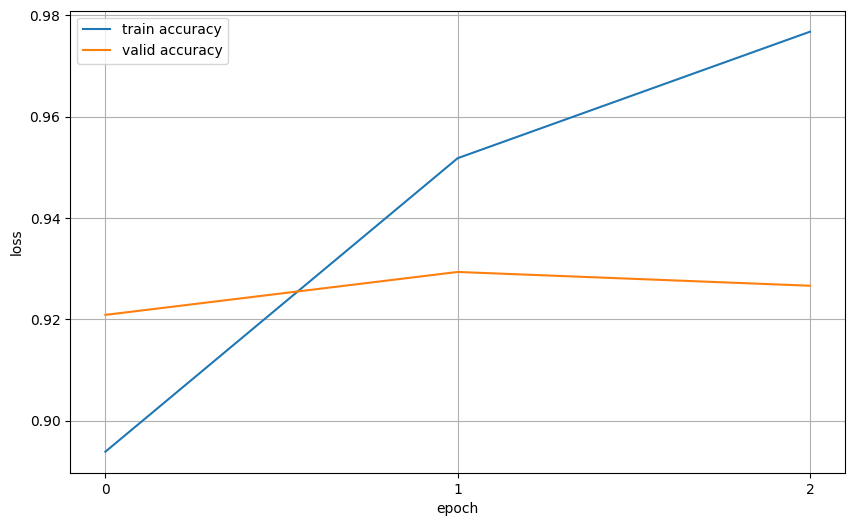

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [38]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 3125/3125 [06:31<00:00,  7.97it/s]


In [39]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.184, test_acc: 0.935


In [40]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [41]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9883214831352234)

In [42]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9944304823875427)

In [43]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9964853525161743)

In [44]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9863978028297424)